to do:
    - write function to combine a list of impacts, with option to cap them on exposures.
    - first put them on a common grid
    - map with qualitative max impact type
    - exceedence frequency curve for multiple hazards

In [3]:
from climada.util.api_client import Client
from climada.util.constants import RIVER_FLOOD_REGIONS_CSV
#from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood,flood_imp_func_set
import pandas as pd
from climada.engine import Impact
from climada.hazard import Hazard
import numpy as np
from climada.util import yearsets
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import xarray as xr
from scipy import sparse
import copy

# Read impact files 


In [4]:
countries = ['TWN', 'DEU', 'VNM', 'COL', 'USA','ITA','AUS', 'HTI', 'MDG']
#Define which files are which, would be good to have standardize names
impact_csvs = {}
impact_mats = {}
impact_csvs_crops = {}
impact_mats_crops = {}
data_dir = '/Users/szelie/OneDrive - ETH Zurich/20211208_Multi-Impact_ZelieCarmen'
for country in countries:
    impact_csvs[country] = {}
    impact_mats[country] = {}
    impact_csvs_crops[country] = {}
    impact_mats_crops[country] = {}
    impact_csvs[country]['RF'] = os.path.join(data_dir, "".join(['river_flood_impact_150arcsec_historical_1980_2000_',country,'.csv']))
    impact_mats[country]['RF'] = os.path.join(data_dir, "".join(['river_flood_impact_150arcsec_historical_1980_2000_',country,'.npz']))


    impact_csvs[country]['TC']  = os.path.join(data_dir, "".join(['TC_impact_mat/imp_',country,'.csv']))
    impact_mats[country]['TC']= os.path.join(data_dir, "".join(['TC_impact_mat/imp_mat_',country,'.npz']))
   
    impact_csvs[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/historical/imp_WF_',country,'.csv']))
    impact_mats[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/historical/imp_mat_WF_',country,'.npz']))
    
    #crops
    for crop in ['mai','ric','soy','whe']:
        impact_csvs_crops[country][crop] = os.path.join(data_dir, "".join(['CP_impact/imp_',country,'_',crop,'_historical.csv']))
        impact_mats_crops[country][crop] = os.path.join(data_dir, "".join(['CP_impact/imp_mat_',country,'_',crop,'_historical.npz']))

    #landslide
    

In [5]:
#sample events per year
import copy

def sum_sparse(mat_list):
    mat_agg = np.zeros(mat_list[0].shape,mat_list[0].dtype)
    for a in mat_list:
        mat_agg[a.nonzero()] += a.data
    return mat_agg

    
def combine_impacts(impact_list, how='sum', exp=None):
    """

    Parameters
    ----------
    impact_list : sparse.csr_matrix
        matrix num_events x num_exp with impacts.
    how : how to combine the impacts, options are 'sum', 'max'
    exposures : If the exposures are given, the impacts are caped at their value
    
    Returns
    -------
    imp : Impact
        Combined impact
    """
    imp = copy.deepcopy(impact_list[0])
    def test_consitency(list_mat):
        if not np.all(list_mat[:-1] == list_mat[1:]):
            LOGGER.warning('The matrices do not have the same shape and will be scaled to the coarser resolution.')
    if how == 'sum':
        sum_mat = np.sum([impact.imp_mat for impact in impact_list],axis=0)
    if exp is not None:
        exp_mat = np.stack([exp.gdf.value.to_numpy() for n in np.unique(years)])
        def sparse_min(A, B):
            """
            Return the element-wise maximum of sparse matrices `A` and `B`.
            """
            AgtB = (A < B).astype(int)
            M = np.multiply(AgtB, A - B) + B
            return sp.sparse.csr_matrix(M)
        sum_mat = sparse_min(sum_mat, exp_mat)
    imp = imp.set_imp_mat(sum_mat)
    return imp

def sample_events(impact, lam=1, years = np.array(range(1980,2000))):
    #create sampling vector
    events_per_year = yearsets.sample_from_poisson(len(years), lam)
    sampling_vect = yearsets.sample_events(events_per_year, impact.frequency)
    impact_sample = yearsets.impact_from_sample(impact, years, sampling_vect)
    return impact_sample 


def open_impacts(country, csv, impact_mat):
    try:
        impact = Impact.from_csv(csv)
        impact.imp_mat = impact.read_sparse_csr(impact_mat)
        return impact
    except:
        print("".join([" No data for ", str(country)]))
        return(None)

def make_yearset(impact, country=None, n_samples=1, years=np.array(range(1,400))):
    lam = np.sum(impact.frequency)
    lam = np.round(lam, 10)
    yearset_list = [sample_events(impact, lam=lam, years=years) for n in range(n_samples)]
    if yearset_list[0].imp_mat.shape[0]>len(years):
        client =Client()
        exposures = client.get_litpop_default(country)
        yearset_list = [yearsets.aggregate_impact_to_year(yearset, exp=exposures) for yearset in yearset_list]        
    return(yearset_list)

def compare_hazards(imp_mats):
    hazard_comparaison = {}
    for hazard in imp_mats:
        comparaison = []
        for other_hazard in list(imp_mats.keys()):
            if (other_hazard!=hazard):
                comparaison.append(((imp_mats[hazard].toarray()>imp_mats[other_hazard].toarray()).astype(int)))
        hazard_comparaison[hazard] =  np.sum(comparaison, axis=0)
    hazard_category = {}
    #return hazard_comparaison
    for n, hazard in enumerate(hazard_comparaison):
        hazard_comparaison[hazard][hazard_comparaison[hazard]!=(len(hazard_comparaison)-1)] = 0
        hazard_comparaison[hazard][hazard_comparaison[hazard]==(len(hazard_comparaison)-1)] = n+1
        hazard_category[(hazard, n+1)] = hazard_comparaison[hazard]

    hazard_category['all'] = np.sum([hazard_category[hazard] for hazard in hazard_category],axis=0)   
    return hazard_category

# make impacts yearsets, 400 years:

In [4]:
impacts = {country:{hazard: open_impacts(country, impact_csvs[country][hazard], 
                                                  impact_mats[country][hazard]) for hazard in impact_csvs[country]} for country in impact_csvs}
impacts_yearsets = {country:{hazard: make_yearset(impacts[country][hazard], country) for hazard in impacts[country] if impacts[country][hazard]!=None} for country in impacts}

 No data for VNM
 No data for COL


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_17097/692901312.py:118: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types.Specify dtype option on import or set low_memory=False.
  impact = Impact.from_csv(csv)


 No data for USA


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [6]:
impacts_crops = {}
impact_crops_combined = {}
for country in impact_csvs_crops:
    impacts_crops[country] = {}
    for crop in impact_csvs_crops[country]:
        impact = Impact.from_csv(impact_csvs_crops[country][crop])
        impact.imp_mat = impact.read_sparse_csr(impact_mats_crops[country][crop])
        impacts_crops[country][crop] = impact
        impacts_list = list(impacts_crops[country].values())
        impact_crops_combined[country] = combine_impacts(impacts_list)
        impact_crops_combined[country] = impact_crops_combined[country].set_imp_mat(sp.sparse.csr_matrix(impact_crops_combined[country].imp_mat))


In [7]:
impacts_yearsets_crops = {}
for country in impact_crops_combined:
    impacts_yearsets_crops[country] = {}
    impacts_yearsets_crops[country]['CP'] = [make_yearset(impact_crops_combined[country], country)[0]]

# Aggregate impacts per grid point

In [10]:
impacts_list = {country: [n[0] for n in impacts_yearsets[country].values()] for country in impacts_yearsets}
total_impacts = {country: combine_impacts(impacts_list[country]) for country in impacts_list} 

# Compare hazard in each point:

In [14]:
matrices_yearsets_aai_exp = {country: {hazard: sp.sparse.csr_matrix(impacts_yearsets[country][hazard][0].imp_mat.sum(axis=0)/400) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}
matrices_yearsets_aai_exp['DEU'].pop('TC')
for country in matrices_yearsets_aai_exp:
    for hazard in matrices_yearsets_aai_exp[country]:
        matrices_yearsets_aai_exp[country][hazard][matrices_yearsets_aai_exp[country][hazard]<100] = 0

hazard_comparaisons_aai = {country: compare_hazards(matrices_yearsets_aai_exp[country]) for country in matrices_yearsets_aai_exp}

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1752: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.scatter(self, *args, **kwargs)


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

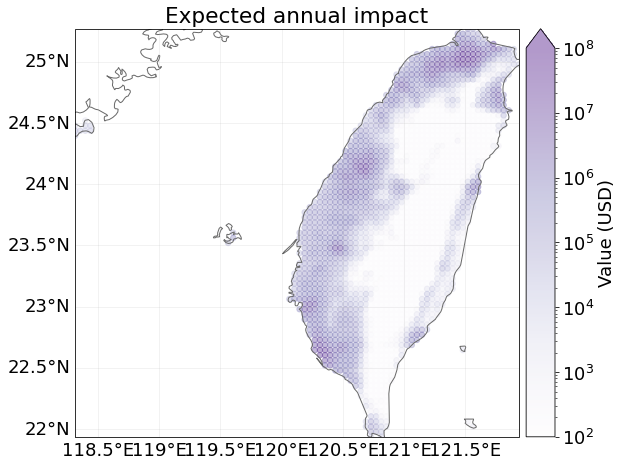

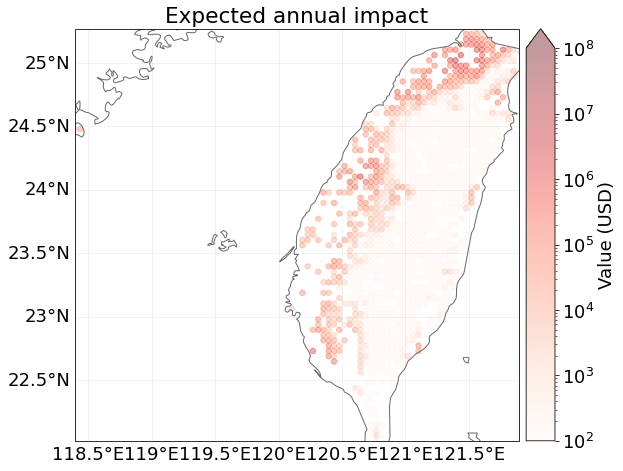

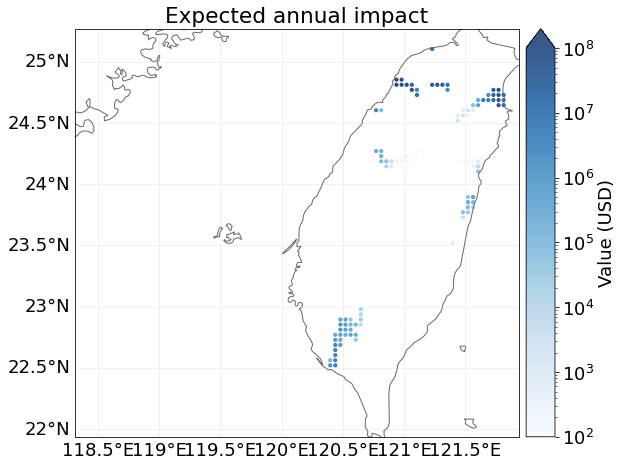

In [16]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
cmap_reversed = matplotlib.cm.get_cmap('magma_r')


#impacts_yearsets["TWN"]['RF'][0].plot_scatter_eai_exposure(s=30,vmax=1e8, vmin=100, cmap='Blues',alpha=0.8, adapt_fontsize=False, extend='max',pop_name=False, norm=matplotlib.colors.LogNorm())

impacts_yearsets["TWN"]['TC'][0].plot_scatter_eai_exposure(s=30,vmax=1e8,  vmin=100, cmap='Purples', alpha=0.4, adapt_fontsize=False, extend='max',pop_name=False, norm=matplotlib.colors.LogNorm())
impacts_yearsets["TWN"]['WF'][0].plot_scatter_eai_exposure(s=30,vmax=1e8,vmin=100, cmap='Reds', alpha=0.4, adapt_fontsize=False, pop_name=False,extend='max', norm=matplotlib.colors.LogNorm())
impacts_yearsets["TWN"]['RF'][0].plot_scatter_eai_exposure(s=10,vmax=1e8, vmin=100, cmap='Blues',alpha=0.8, adapt_fontsize=False, extend='max',pop_name=False, norm=matplotlib.colors.LogNorm(), ignore_zero=False)



['no damage', 'RF', 'TC', 'WF']
['no damage', 'RF', 'WF']
['no damage', 'RF', 'TC']
['no damage', 'RF', 'TC']
['no damage', 'RF', 'TC']


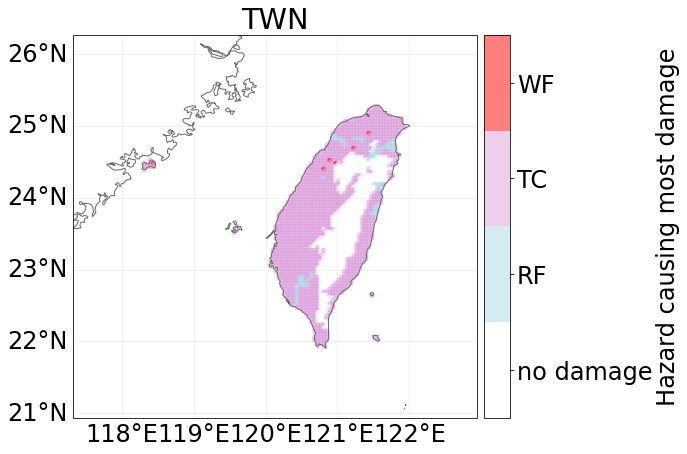

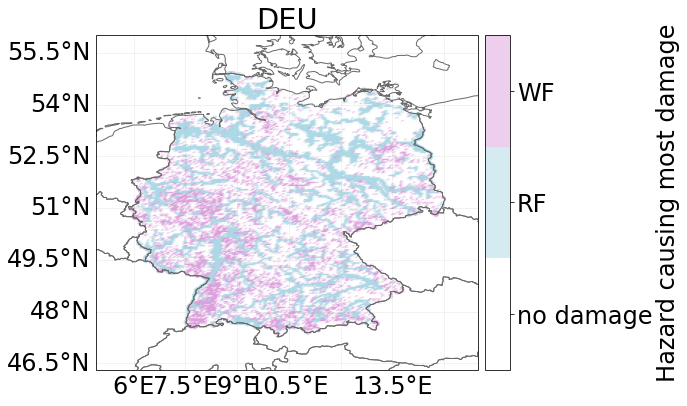

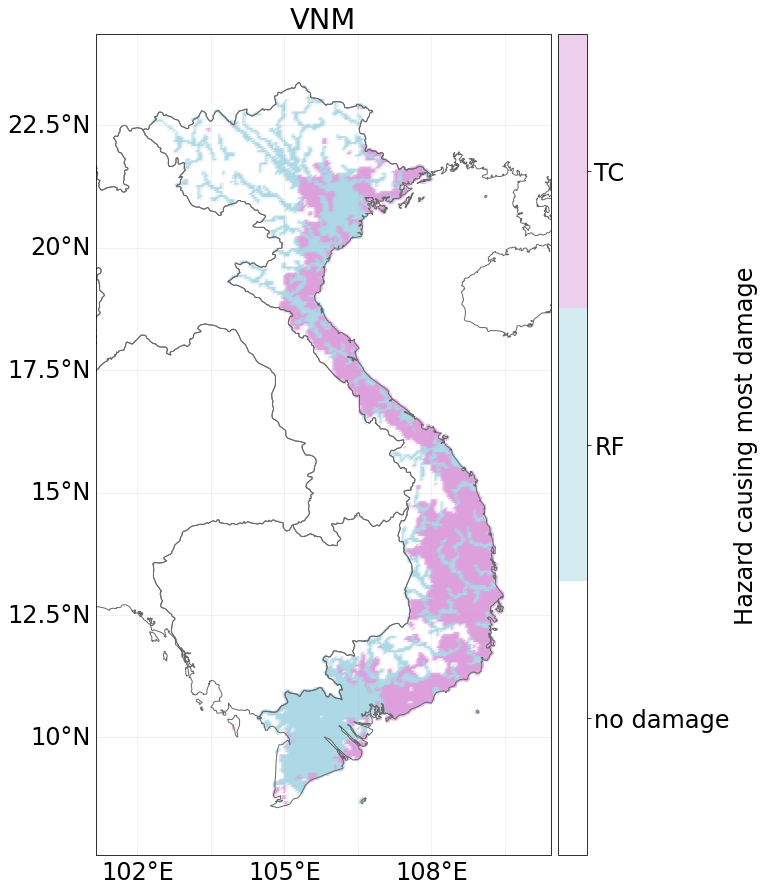

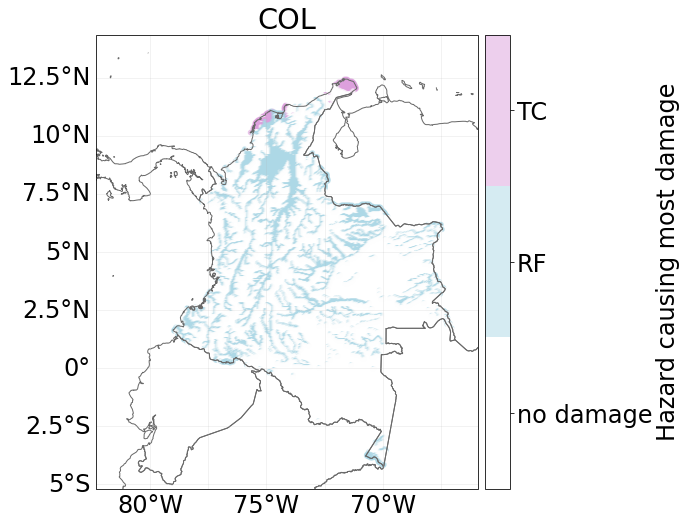

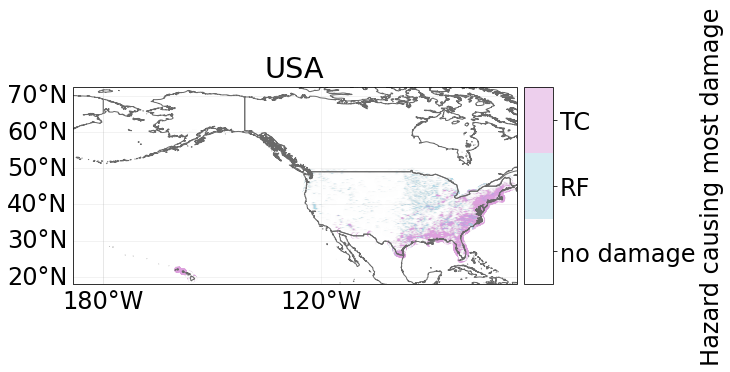

In [17]:
from climada.util.plot import geo_scatter_categorical
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 24})


color_list = ['white','lightblue','plum', 'red']

for country in hazard_comparaisons_aai:
    cat_name = ['no damage']
    [cat_name.append(cat[0]) for cat in list(hazard_comparaisons_aai[country].keys()) if cat!='all']
    print(cat_name)
    cmap =  ListedColormap(color_list[0:len(cat_name)])
    geo_scatter_categorical(hazard_comparaisons_aai[country]['all'], impacts_yearsets[country]['RF'][0].coord_exp, 'Hazard causing most damage', title=country,
                          cat_name=cat_name, cmap=cmap, alpha=0.5, s=20, adapt_fontsize=False)



<GeoAxesSubplot:title={'center':'Expected annual impact'}>

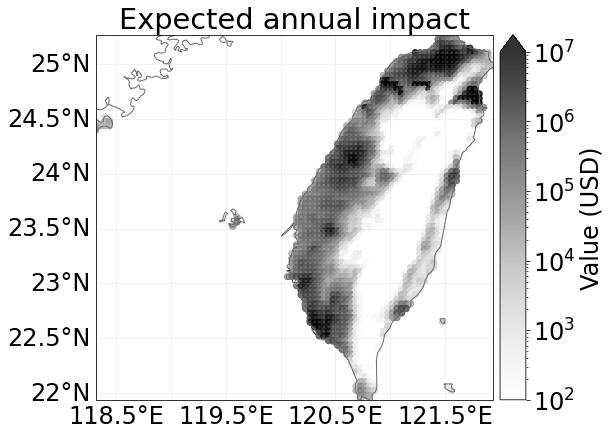

In [19]:
total_impacts["TWN"].plot_scatter_eai_exposure(s=40,vmax=1e7, vmin=100, cmap='Greys',alpha=0.8, adapt_fontsize=False, extend='max',pop_name=False, norm=matplotlib.colors.LogNorm())



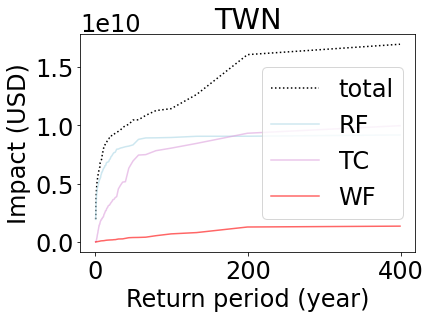

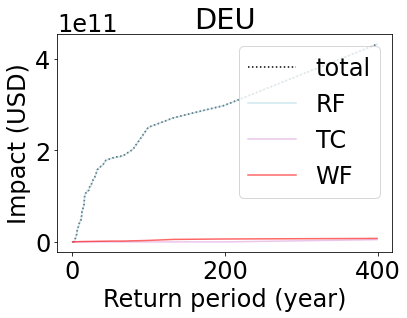

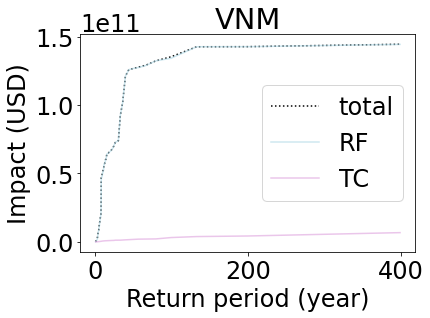

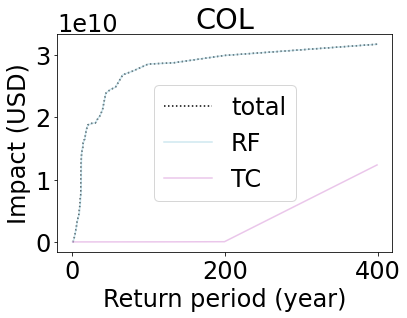

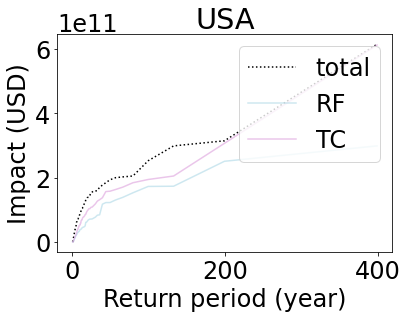

In [20]:
colors={'RF':'lightblue', 'WF':'red', 'TC':'plum'}
for country in total_impacts:
    ax = total_impacts[country].calc_freq_curve().plot(linestyle=':',label='total', color='black')

    for hazard in impacts_yearsets[country]:
        impacts_yearsets[country][hazard][0].calc_freq_curve().plot(axis=ax, label=hazard,  alpha=0.6, color=colors[hazard])



    ax.legend()
    ax.set_title(country)